In [ ]:
!wget https://huggingface.co/danjacobellis/LCCL/resolve/main/colorize_pixels_512_p32.pth

In [2]:
import torch
import torch.nn as nn
import numpy as np
import warnings
import IPython.display
import io
from PIL import Image
from einops import rearrange
from datasets import load_dataset
from torchvision.transforms import (
    RandomResizedCrop, Resize, Grayscale,
    PILToTensor, ToPILImage, 
    Compose, RandomHorizontalFlip )
from max_vit_with_register_tokens import MaxViT
from fastprogress.fastprogress import master_bar, progress_bar
class Config: pass

In [17]:
device = "cuda"
checkpoint = torch.load("colorize_pixels_512_p32.pth",map_location="cpu",weights_only=False)
config = checkpoint['config']
model = MaxViT(
    channels = config.channels,
    patch_size = config.patch_size,
    num_classes = config.num_classes,
    dim = config.embed_dim,
    depth = config.depth,
    downsample = config.downsample,
    # heads = config.heads, # calculated as dim//dim_head  
    # mlp_dim = config.mlp_dim, # calculated as 4*dim
    dim_head = config.dim_head,
    dim_conv_stem = config.dim_conv_stem,
    window_size = config.window_size,
    mbconv_expansion_rate = config.mbconv_expansion_rate,
    mbconv_shrinkage_rate = config.mbconv_shrinkage_rate,
    dropout = config.dropout,
    num_register_tokens = config.num_register_tokens,
    dense_prediction=True
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [10]:
dataset_valid = load_dataset('imagenet-1k',split='validation',trust_remote_code=True)

imagenet-1k.py:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

classes.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

In [11]:
L = config.image_size
C = config.channels

valid_transform = Compose([
    Resize(
        size=(L,L),
        interpolation=Image.Resampling.LANCZOS
    ),
    PILToTensor(),
])

def valid_collate_fn(batch):
    B = len(batch)    
    x = torch.zeros( (B, C, L, L), dtype=torch.uint8)
    y = []
    for i_sample, sample in enumerate(batch):
        img = sample['image'].convert("RGB")
        x[i_sample,:,:,:] = Grayscale(num_output_channels=3)(valid_transform(img))
        y.append(img)
    return x, y

In [18]:
data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)
pb_valid = progress_bar(data_loader_valid)
valid_loss_per_sample = []
for i_batch, (x,y) in enumerate(pb_valid):
    x = x.to(torch.float)
    x = x / 255
    x = x.to(device)
    with torch.no_grad():
        pred = torch.nn.Hardtanh(min_val=0,max_val=1)(model(x))
        for i_valid, yi in enumerate(y):
            pred_i = Resize(size=(yi.height, yi.width))(pred[i_valid])
            yi = PILToTensor()(yi)
            yi = yi.to(torch.float)
            yi = yi / 255
            yi = yi.to(device)
            loss = nn.functional.mse_loss(pred_i, yi)
            valid_loss_per_sample.append(loss.item())

In [23]:
-10*np.log10(np.mean(valid_loss_per_sample))

20.639066841276872

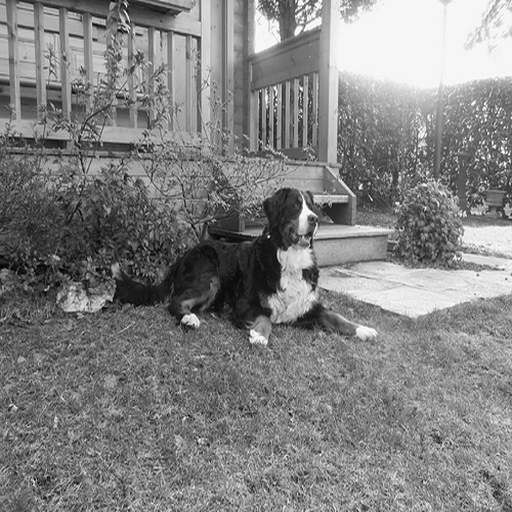

In [25]:
ToPILImage()(x[i_valid])

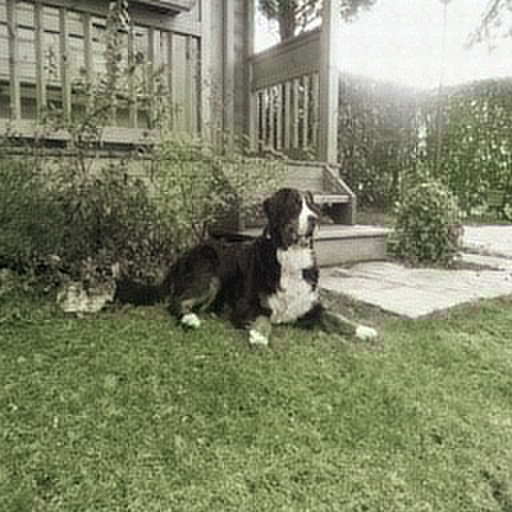

In [26]:
ToPILImage()(pred[i_valid])

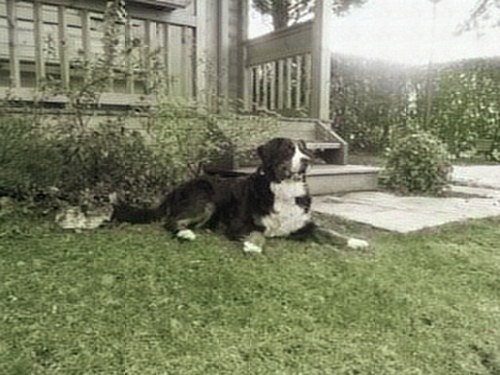

In [21]:
ToPILImage()(pred_i)

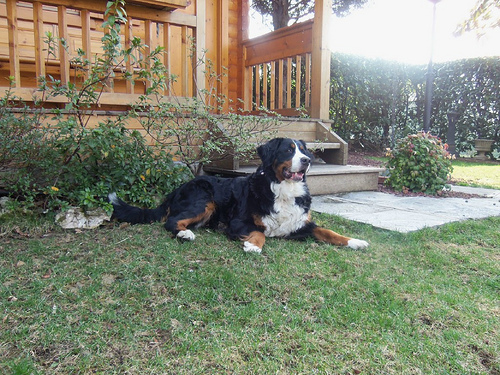

In [24]:
ToPILImage()(yi)